In [1]:
%matplotlib inline
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from poison_evaluation.models import ResNet18
from tqdm import tqdm

In [2]:
cifar_path = '/vulcanscratch/psando/cifar-10'
cifar_ckpt_dir = '/vulcanscratch/psando/cifar_model_ckpts/poisoned/targeted_250'
model_name = 'resnet18'
model = ResNet18()

pretrained_path = os.path.join(cifar_ckpt_dir, str.lower(model_name) + '.pt')
print(f'==> Loading standard checkpoint {pretrained_path}')
ckpt = torch.load(pretrained_path)
state_dict = ckpt['model']
# Standard models were trained using DataParallel, so keys are 
# in a different format
state_dict = {k[len('module.'):]: v for k,v in state_dict.items()}
model.load_state_dict(state_dict, strict=True)
model = model.cuda()
model = model.eval()

==> Loading standard checkpoint /vulcanscratch/psando/cifar_model_ckpts/poisoned/targeted_250/resnet18.pt


In [3]:
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

testset = torchvision.datasets.CIFAR10(
        root=cifar_path, train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=1)

In [4]:
heatmap = torch.zeros((10, 10))

for x, y in tqdm(testloader):
    x, y = x.cuda(), y.cuda()
    out = model(x)
    pred = torch.argmax(out, dim=1)
    
    # for every GT class, log the prediction
    for i, y_c in enumerate(y):
        pred_y_c = pred[i].item()
        heatmap[y_c][pred_y_c] += 1
        
# normalize
for row in range(heatmap.size(0)):
    heatmap[row] /= 1000
        
print(heatmap)
heatmap = heatmap.numpy()

100%|██████████| 100/100 [00:05<00:00, 16.98it/s]

tensor([[0.2350, 0.3450, 0.0230, 0.0090, 0.0010, 0.0940, 0.2280, 0.0450, 0.0060,
         0.0140],
        [0.4260, 0.2590, 0.0120, 0.0040, 0.0020, 0.0860, 0.1100, 0.0540, 0.0290,
         0.0180],
        [0.0320, 0.2340, 0.0490, 0.0390, 0.0130, 0.4790, 0.1400, 0.0120, 0.0000,
         0.0020],
        [0.0140, 0.0610, 0.1620, 0.0260, 0.0190, 0.5380, 0.1640, 0.0140, 0.0010,
         0.0010],
        [0.0120, 0.0500, 0.0650, 0.1780, 0.0380, 0.4370, 0.1870, 0.0310, 0.0010,
         0.0010],
        [0.0030, 0.0430, 0.1020, 0.0210, 0.0370, 0.6540, 0.1350, 0.0040, 0.0010,
         0.0000],
        [0.0070, 0.0630, 0.0530, 0.0350, 0.0400, 0.5160, 0.2840, 0.0020, 0.0000,
         0.0000],
        [0.0020, 0.0500, 0.0730, 0.0270, 0.0370, 0.2310, 0.5250, 0.0540, 0.0000,
         0.0010],
        [0.2010, 0.2000, 0.0030, 0.0050, 0.0000, 0.1270, 0.0690, 0.3810, 0.0090,
         0.0050],
        [0.0940, 0.1530, 0.0460, 0.0090, 0.0040, 0.1670, 0.2970, 0.1310, 0.0550,
         0.0440]])


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck')

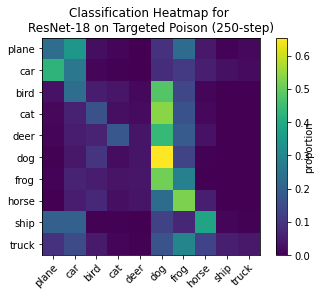

In [6]:
ax = plt.gca()
im = ax.imshow(heatmap)

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

cbarlabel = 'proportion'
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(cbarlabel, rotation=90, va="bottom")

ax.set_title("Classification Heatmap for \nResNet-18 on Targeted Poison (250-step)")

plt.show()